# Synthetic Dataset

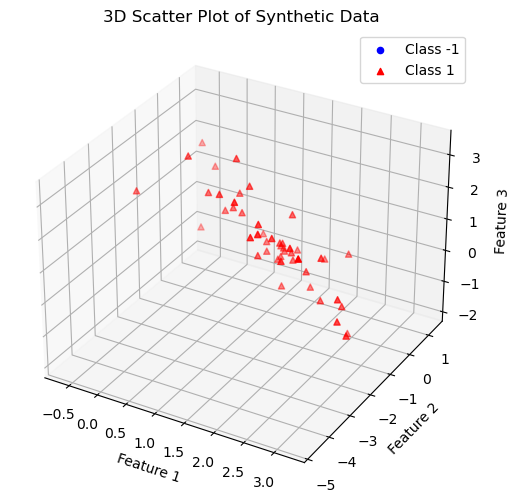

In [50]:
import numpy as np
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
import torch

# Set the random seed for reproducibility
np.random.seed(42)

# Generate synthetic data with 3 features
X, y = make_classification(n_samples=100, n_features=3, n_informative=3, n_redundant=0,
                           n_clusters_per_class=1, weights=[0.5, 0.5], flip_y=0.05, class_sep=1.5)
# y = 2*y - 1
# Plotting the dataset
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for each class
ax.scatter(X[y == -1][:, 0], X[y == -1][:, 1], X[y == -1][:, 2], c='b', marker='o', label='Class -1')
ax.scatter(X[y == 1][:, 0], X[y == 1][:, 1], X[y == 1][:, 2], c='r', marker='^', label='Class 1')

ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Feature 3')
ax.set_title('3D Scatter Plot of Synthetic Data')
ax.legend()

plt.show()


# Linear Classifier

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

# Linear classifier model
class LinearClassifier(nn.Module):
    def __init__(self, num_features):
        super(LinearClassifier, self).__init__()
        self.linear = nn.Linear(num_features, 1)
    
    def forward(self, x):
        return torch.sigmoid(self.linear(x))

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# Instantiate the model
model = LinearClassifier(num_features=3)

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Split data into training and testing
dataset = torch.utils.data.TensorDataset(X_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    for data, targets in train_loader:
        # Forward pass
        outputs = model(data).squeeze()
        loss = criterion(outputs, targets)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


In [39]:
# Function to calculate accuracy
def calculate_accuracy(loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, labels in loader:
            outputs = model(data).squeeze()
            predicted = outputs.round()  # Threshold at 0.5
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

# Accuracy on the test set
test_accuracy = calculate_accuracy(test_loader)
print(f'Accuracy of the linear classifier on test data is: {test_accuracy:.2f}%')


Accuracy of the linear classifier on test data is: 95.50%


# Labeling Functions

In [43]:
import torch

def lf1(x):
    # Label 1 if the first feature > 1, else 0
    return (x[:, 0] > 1).float()

def lf2(x):
    # Label 1 if the second feature > 0, else 0
    return (x[:, 1] > 2).float()

def lf_classifier(x):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient computation
        # Ensure input is a PyTorch tensor and reshape it appropriately if it's just one sample
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, dtype=torch.float32)
        if x.dim() == 1:
            x = x.unsqueeze(0)
        
        # Get the model's probability output
        probabilities = model(x).squeeze()
        
        # Convert probabilities to binary labels based on a 0.5 threshold
        labels = (probabilities >= 0.5).float()
        return labels

In [34]:
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)


In [6]:
labels_lf1 = lf1(X_tensor)
labels_lf2 = lf2(X_tensor)
labels_lf3 = lf_classifier(X_tensor)


# Controlled Array Labeling Functions

In [54]:
# The true accuracies for labeling functions

lf1_alpha_hat = 0.82
lf2_alpha_hat = 0.8
lf3_alpha_hat = 0.1


change_index_1 = np.floor((1 - lf1_alpha_hat) * y.shape[0]).astype(int)

not_array_1 = y[:change_index_1]
not_array_1 = 1 - not_array_1

labeling_function_1_array = y
labeling_function_1_array[:change_index_1] = not_array_1



change_index_2 = np.floor((1 - lf2_alpha_hat) * y.shape[0]).astype(int)

not_array_2 = y[:change_index_2]
not_array_2 = 1 - not_array_2

labeling_function_2_array = y
labeling_function_2_array[:change_index_2] = not_array_2



change_index_3 = np.floor((1 - lf3_alpha_hat) * y.shape[0]).astype(int)

not_array_3 = y[:change_index_3]
not_array_3 = 1 - not_array_3

labeling_function_3_array = y
labeling_function_3_array[:change_index_3] = not_array_3

X_tensor = torch.tensor(X, dtype=torch.float32)
labeling_function_1_array = torch.tensor(labeling_function_1_array)
labeling_function_2_array = torch.tensor(labeling_function_2_array)
labeling_function_3_array = torch.tensor(labeling_function_3_array)

# Generative Model Training

Using the arrays

In [52]:
# Initialize accuracy parameters for all three labeling functions
acc_lf1 = torch.tensor(0.81, requires_grad=True)
acc_lf2 = torch.tensor(0.815, requires_grad=True)
acc_lf3 = torch.tensor(0.8155, requires_grad=True)  # New parameter for the classifier LF

# Optimizer includes the new accuracy parameter
optimizer = torch.optim.SGD([acc_lf1, acc_lf2, acc_lf3], lr=0.01)

# Batch size for mini-batch SGD (1 for true SGD, larger for mini-batch SGD)
batch_size = 1  # Change this to larger sizes like 64, 128, etc., for mini-batch SGD

# DataLoader for iterating through the data
data_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_tensor, 
                                                                         labeling_function_1_array, 
                                                                         labeling_function_2_array,
                                                                         labeling_function_3_array), 
                                          batch_size=batch_size, 
                                          shuffle=False)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
num_epochs = 100
total_losses = []
for epoch in range(num_epochs):
    
    initial_loss = 0
    optimizer.zero_grad()
    
    for data in data_loader:
        
        # optimizer.zero_grad()
        x, labels_lf1_batch, labels_lf2_batch, labels_lf3_batch = data  # We do not use y_tensor since we are estimating LF accuracies
#         x = x.to(device)
#         labels_lf1_batch = labels_lf1_batch.to(device)
#         labels_lf2_batch = labels_lf2_batch.to(device)
#         labels_lf3_batch = labels_lf3_batch.to(device)
        # Compute probabilities for each label function and each class
        # Similar to previous code, but applied to the batch
        # p_lf1_given_y1 = acc_lf1 * labels_lf1_batch + (1 - acc_lf1) * (1 - labels_lf1_batch)
        # p_lf2_given_y1 = acc_lf2 * labels_lf2_batch + (1 - acc_lf2) * (1 - labels_lf2_batch)
        # p_lf3_given_y1 = acc_lf3 * labels_lf3_batch + (1 - acc_lf3) * (1 - labels_lf3_batch)
        
        # p_lf1_given_y0 = (1 - acc_lf1) * labels_lf1_batch + acc_lf1 * (1 - labels_lf1_batch)
        # p_lf2_given_y0 = (1 - acc_lf2) * labels_lf2_batch + acc_lf2 * (1 - labels_lf2_batch)
        # p_lf3_given_y0 = (1 - acc_lf3) * labels_lf3_batch + acc_lf3 * (1 - labels_lf3_batch)

        p_lf1_given_y1 = torch.sigmoid(acc_lf1) * labels_lf1_batch + (1 - torch.sigmoid(acc_lf1)) * (1 - labels_lf1_batch)
        p_lf2_given_y1 = torch.sigmoid(acc_lf2) * labels_lf2_batch + (1 - torch.sigmoid(acc_lf2)) * (1 - labels_lf2_batch)
        p_lf3_given_y1 = torch.sigmoid(acc_lf3) * labels_lf3_batch + (1 - torch.sigmoid(acc_lf3)) * (1 - labels_lf3_batch)
        
        p_lf1_given_y0 = (1 - torch.sigmoid(acc_lf1)) * labels_lf1_batch + torch.sigmoid(acc_lf1) * (1 - labels_lf1_batch)
        p_lf2_given_y0 = (1 - torch.sigmoid(acc_lf2)) * labels_lf2_batch + torch.sigmoid(acc_lf2) * (1 - labels_lf2_batch)
        p_lf3_given_y0 = (1 - torch.sigmoid(acc_lf3)) * labels_lf3_batch + torch.sigmoid(acc_lf3) * (1 - labels_lf3_batch)
        
        joint_prob_y1 = p_lf1_given_y1 * p_lf2_given_y1 * p_lf3_given_y1
        joint_prob_y0 = p_lf1_given_y0 * p_lf2_given_y0 * p_lf3_given_y0
        
        total_prob = 0.5 * (joint_prob_y1 + joint_prob_y0)
        
        loss = torch.log(total_prob + 1e-9).mean()

        initial_loss = initial_loss + loss
        
    initial_loss = -initial_loss
    total_losses.append(initial_loss.item())
    initial_loss.backward()
    optimizer.step()

    if epoch % 5 == 0:
        print(f"Epoch {epoch}: Loss = {initial_loss.item()}")
        print(f"Epoch {epoch}: LF1 Acc = {torch.sigmoid(acc_lf1).item()}, LF2 Acc = {torch.sigmoid(acc_lf2).item()}, LF3 Acc = {torch.sigmoid(acc_lf3).item()}")
        # print(f"Epoch {epoch}: LF1 Acc = {acc_lf1.item()}, LF2 Acc = {acc_lf2.item()}, LF3 Acc = {acc_lf3.item()}")




Epoch 0: Loss = 118.80371856689453
Epoch 0: LF1 Acc = 0.7667933702468872, LF2 Acc = 0.7673690319061279, LF3 Acc = 0.7674266695976257
Epoch 5: Loss = 29.619159698486328
Epoch 5: LF1 Acc = 0.8980397582054138, LF2 Acc = 0.8981530070304871, LF3 Acc = 0.8981642723083496
Epoch 10: Loss = 12.347853660583496
Epoch 10: LF1 Acc = 0.9350098371505737, LF2 Acc = 0.9350565075874329, LF3 Acc = 0.9350612163543701
Epoch 15: Loss = 5.125698089599609
Epoch 15: LF1 Acc = 0.9523246884346008, LF2 Acc = 0.9523500800132751, LF3 Acc = 0.9523525834083557
Epoch 20: Loss = 1.1629819869995117
Epoch 20: LF1 Acc = 0.9623594284057617, LF2 Acc = 0.9623753428459167, LF3 Acc = 0.9623768925666809


KeyboardInterrupt: 

In [58]:
import numpy as np
import torch
import plotly.graph_objects as go

# Define the loss function as before
def compute_loss(acc_lf1, acc_lf2, acc_lf3_value):
    acc_lf3 = torch.tensor(acc_lf3_value, requires_grad=False)
    initial_loss = 0
    
    for data in data_loader:
        
        # optimizer.zero_grad()
        x, labels_lf1_batch, labels_lf2_batch, labels_lf3_batch = data  # We do not use y_tensor since we are estimating LF accuracies
#         x = x.to(device)
#         labels_lf1_batch = labels_lf1_batch.to(device)
#         labels_lf2_batch = labels_lf2_batch.to(device)
#         labels_lf3_batch = labels_lf3_batch.to(device)
        # Compute probabilities for each label function and each class
        # Similar to previous code, but applied to the batch
        # p_lf1_given_y1 = acc_lf1 * labels_lf1_batch + (1 - acc_lf1) * (1 - labels_lf1_batch)
        # p_lf2_given_y1 = acc_lf2 * labels_lf2_batch + (1 - acc_lf2) * (1 - labels_lf2_batch)
        # p_lf3_given_y1 = acc_lf3 * labels_lf3_batch + (1 - acc_lf3) * (1 - labels_lf3_batch)
        
        # p_lf1_given_y0 = (1 - acc_lf1) * labels_lf1_batch + acc_lf1 * (1 - labels_lf1_batch)
        # p_lf2_given_y0 = (1 - acc_lf2) * labels_lf2_batch + acc_lf2 * (1 - labels_lf2_batch)
        # p_lf3_given_y0 = (1 - acc_lf3) * labels_lf3_batch + acc_lf3 * (1 - labels_lf3_batch)

        p_lf1_given_y1 = torch.sigmoid(acc_lf1) * labels_lf1_batch + (1 - torch.sigmoid(acc_lf1)) * (1 - labels_lf1_batch)
        p_lf2_given_y1 = torch.sigmoid(acc_lf2) * labels_lf2_batch + (1 - torch.sigmoid(acc_lf2)) * (1 - labels_lf2_batch)
        p_lf3_given_y1 = torch.sigmoid(acc_lf3) * labels_lf3_batch + (1 - torch.sigmoid(acc_lf3)) * (1 - labels_lf3_batch)
        
        p_lf1_given_y0 = (1 - torch.sigmoid(acc_lf1)) * labels_lf1_batch + torch.sigmoid(acc_lf1) * (1 - labels_lf1_batch)
        p_lf2_given_y0 = (1 - torch.sigmoid(acc_lf2)) * labels_lf2_batch + torch.sigmoid(acc_lf2) * (1 - labels_lf2_batch)
        p_lf3_given_y0 = (1 - torch.sigmoid(acc_lf3)) * labels_lf3_batch + torch.sigmoid(acc_lf3) * (1 - labels_lf3_batch)
        
        joint_prob_y1 = p_lf1_given_y1 * p_lf2_given_y1 * p_lf3_given_y1
        joint_prob_y0 = p_lf1_given_y0 * p_lf2_given_y0 * p_lf3_given_y0
        
        total_prob = 0.5 * (joint_prob_y1 + joint_prob_y0)
        
        loss = torch.log(total_prob + 1e-9).mean()

        initial_loss = initial_loss + loss
        
#     initial_loss = -initial_loss

    return initial_loss.item()

# Setup the grid of values
values = np.linspace(0, 1, 20)
acc_lf1_values, acc_lf2_values = np.meshgrid(values, values)
losses = np.zeros_like(acc_lf1_values)

# Compute losses
for i in range(len(values)):
    for j in range(len(values)):
        loss = compute_loss(torch.tensor(acc_lf1_values[i, j]), torch.tensor(acc_lf2_values[i, j]), 0.8155)
        losses[i, j] = loss

# Create the plot
fig = go.Figure(data=[go.Surface(z=losses, x=acc_lf1_values, y=acc_lf2_values)])
fig.update_layout(title='Loss Landscape', autosize=True,
                  margin=dict(l=65, r=50, b=65, t=90),
                  scene=dict(
                      xaxis_title='LF1 Accuracy',
                      yaxis_title='LF2 Accuracy',
                      zaxis_title='Loss'))
fig.show()


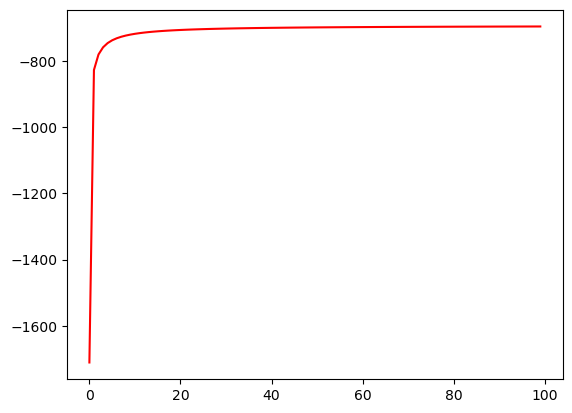

In [23]:
plt.plot(-np.array(total_losses), 'r')

Using the Functions

In [44]:
# Initialize accuracy parameters for all three labeling functions
acc_lf1 = torch.tensor(0.1, requires_grad=True)
acc_lf2 = torch.tensor(0.1, requires_grad=True)
acc_lf3 = torch.tensor(0.1, requires_grad=True)  # New parameter for the classifier LF

# Optimizer includes the new accuracy parameter
optimizer = torch.optim.SGD([acc_lf1, acc_lf2, acc_lf3], lr=0.001)

# Batch size for mini-batch SGD (1 for true SGD, larger for mini-batch SGD)
batch_size = 1  # Change this to larger sizes like 64, 128, etc., for mini-batch SGD

# DataLoader for iterating through the data
data_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_tensor, y_tensor), batch_size=batch_size, shuffle=False)

num_epochs = 100
for epoch in range(num_epochs):
    
    initial_loss = 0
    optimizer.zero_grad()
    
    for data in data_loader:
        
        # optimizer.zero_grad()
        
        x_batch, _ = data  # We do not use y_tensor since we are estimating LF accuracies
        

        labels_lf1_batch = lf1(x_batch)
        labels_lf2_batch = lf2(x_batch)
        labels_lf3_batch = lf_classifier(x_batch)  # Assuming lf_classifier is prepared for batch processing

        # Compute probabilities for each label function and each class
        # Similar to previous code, but applied to the batch
        # p_lf1_given_y1 = acc_lf1 * labels_lf1_batch + (1 - acc_lf1) * (1 - labels_lf1_batch)
        # p_lf2_given_y1 = acc_lf2 * labels_lf2_batch + (1 - acc_lf2) * (1 - labels_lf2_batch)
        # p_lf3_given_y1 = acc_lf3 * labels_lf3_batch + (1 - acc_lf3) * (1 - labels_lf3_batch)
        
        # p_lf1_given_y0 = (1 - acc_lf1) * labels_lf1_batch + acc_lf1 * (1 - labels_lf1_batch)
        # p_lf2_given_y0 = (1 - acc_lf2) * labels_lf2_batch + acc_lf2 * (1 - labels_lf2_batch)
        # p_lf3_given_y0 = (1 - acc_lf3) * labels_lf3_batch + acc_lf3 * (1 - labels_lf3_batch)

        p_lf1_given_y1 = torch.sigmoid(acc_lf1) * labels_lf1_batch + (1 - torch.sigmoid(acc_lf1)) * (1 - labels_lf1_batch)
        p_lf2_given_y1 = torch.sigmoid(acc_lf2) * labels_lf2_batch + (1 - torch.sigmoid(acc_lf2)) * (1 - labels_lf2_batch)
        p_lf3_given_y1 = torch.sigmoid(acc_lf3) * labels_lf3_batch + (1 - torch.sigmoid(acc_lf3)) * (1 - labels_lf3_batch)
        
        p_lf1_given_y0 = (1 - torch.sigmoid(acc_lf1)) * labels_lf1_batch + torch.sigmoid(acc_lf1) * (1 - labels_lf1_batch)
        p_lf2_given_y0 = (1 - torch.sigmoid(acc_lf2)) * labels_lf2_batch + torch.sigmoid(acc_lf2) * (1 - labels_lf2_batch)
        p_lf3_given_y0 = (1 - torch.sigmoid(acc_lf3)) * labels_lf3_batch + torch.sigmoid(acc_lf3) * (1 - labels_lf3_batch)
        
        joint_prob_y1 = p_lf1_given_y1 * p_lf2_given_y1 * p_lf3_given_y1
        joint_prob_y0 = p_lf1_given_y0 * p_lf2_given_y0 * p_lf3_given_y0
        
        total_prob = 0.5 * (joint_prob_y1 + joint_prob_y0)
        
        loss = -torch.log(total_prob + 1e-9).mean()

        initial_loss = initial_loss + loss
        
    initial_loss.backward()
    optimizer.step()

    if epoch % 1 == 0:
        print(f"Epoch {epoch}: Loss = {initial_loss.item()}")
        print(f"Epoch {epoch}: LF1 Acc = {torch.sigmoid(acc_lf1).item()}, LF2 Acc = {torch.sigmoid(acc_lf2).item()}, LF3 Acc = {torch.sigmoid(acc_lf3).item()}")

Epoch 0: Loss = 2075.951904296875
Epoch 0: LF1 Acc = 0.5275577902793884, LF2 Acc = 0.5323365926742554, LF3 Acc = 0.5323490500450134
Epoch 1: Loss = 2073.865234375
Epoch 1: LF1 Acc = 0.5308534502983093, LF2 Acc = 0.5415493249893188, LF3 Acc = 0.5415723323822021
Epoch 2: Loss = 2070.54833984375
Epoch 2: LF1 Acc = 0.5350073575973511, LF2 Acc = 0.5530248284339905, LF3 Acc = 0.5530573725700378
Epoch 3: Loss = 2065.435302734375
Epoch 3: LF1 Acc = 0.5401578545570374, LF2 Acc = 0.5672008395195007, LF3 Acc = 0.5672426819801331
Epoch 4: Loss = 2057.55810546875
Epoch 4: LF1 Acc = 0.5464106202125549, LF2 Acc = 0.5844919085502625, LF3 Acc = 0.584542989730835
Epoch 5: Loss = 2045.7607421875
Epoch 5: LF1 Acc = 0.5537868142127991, LF2 Acc = 0.605189323425293, LF3 Acc = 0.6052497029304504
Epoch 6: Loss = 2028.59716796875
Epoch 6: LF1 Acc = 0.562155544757843, LF2 Acc = 0.6293123960494995, LF3 Acc = 0.629382312297821
Epoch 7: Loss = 2004.819091796875
Epoch 7: LF1 Acc = 0.5711721181869507, LF2 Acc = 0.656

# Classifying Using Noise-Aware Loss Function

In [50]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, random_split

# Create a dataset
full_dataset = TensorDataset(X_tensor, y_tensor)  # Assuming y_tensor is the true labels

# Split the dataset into train and test sets
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Create data loaders for training and testing
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

class SimpleModel(nn.Module):
    def __init__(self, input_dim):
        super(SimpleModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)  # Output is a single value (logit)

    def forward(self, x):
        return self.linear(x)  # Returns logits

def evaluate_model(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient computation during inference
        for data, labels in data_loader:
            outputs = model(data)
            predicted = torch.sigmoid(outputs).round()  # Convert logits to binary predictions
            total += labels.size(0)
            correct += (predicted == labels.unsqueeze(1)).sum().item()

    accuracy = correct / total
    return accuracy


In [62]:
test_accuracy = evaluate_model(model, test_loader)
print(f'Test Accuracy: {test_accuracy:.4f}')

Test Accuracy: 0.4250


In [46]:
def noise_aware_loss(logits, labels, acc_lfs):
    """
    logits: output from the model
    labels: labels from labeling functions
    acc_lfs: accuracies of the labeling functions
    """
    sigmoids = torch.sigmoid(logits)
    loss = 0
    for i, acc in enumerate(acc_lfs):
        # Estimated probability of true label being 1 given the label from LF
        p_y_given_lf1 = labels[:, i] * acc + (1 - labels[:, i]) * (1 - acc)
        # Binary cross-entropy term for each LF
        loss += -p_y_given_lf1 * torch.log(sigmoids) - (1 - p_y_given_lf1) * torch.log(1 - sigmoids)
    return loss.mean()


In [55]:
def noise_aware_loss(logits, labels, acc_lfs):
    sigmoids = torch.sigmoid(logits)
    loss = 0
    for i, acc in enumerate(acc_lfs):
        
        p_y_given_lf = labels[:, i] * acc + (1 - labels[:, i]) * (1 - acc)
        
        loss += -p_y_given_lf * torch.log(sigmoids + 1e-9) - (1 - p_y_given_lf) * torch.log(1 - sigmoids + 1e-9)
        
    return loss.mean()

# Accuracies estimated from previous steps, converted to a tensor
acc_lfs = torch.tensor([acc_lf1.item(), acc_lf2.item(), acc_lf3.item()], requires_grad=False)

# Labels matrix combining all labeling functions
labels_matrix = torch.stack([labels_lf1, labels_lf2, labels_lf3], dim=1).float()


In [61]:
model = SimpleModel(input_dim=3)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
num_epochs = 50

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for data, targets in train_loader:
        target_labels = torch.tensor(np.array([lf1(data),lf2(data),lf_classifier(data)]))
        optimizer.zero_grad()
        logits = model(data)
        
        loss = noise_aware_loss(logits, target_labels, acc_lfs)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    if epoch % 10 == 0:
        print(f'Epoch {epoch}: Average Loss = {total_loss / len(train_loader)}')


Epoch 0: Average Loss = -4.317668999616917
Epoch 10: Average Loss = -28.560574311476486
Epoch 20: Average Loss = -34.28257245283861
Epoch 30: Average Loss = -62.868141174316406
Epoch 40: Average Loss = -71.62599101433388


In [64]:
total_loss

-1154.9387950897217